In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pycalphad import Database, calculate, equilibrium, binplot
import pycalphad.variables as v
from binary_helpers import plot_convex_hull

# Load database and choose the phases that will be considered
dbf = Database('Cr-Fe-ref2.TDB')
comps = ['CR', 'FE', 'VA']
phases = sorted(dbf.phases)

eq_alni = equilibrium(dbf, ['CR', 'FE', 'VA'], phases, {v.X('FE'): 0.5, v.T: (300, 2500, 20), v.P: 101325})


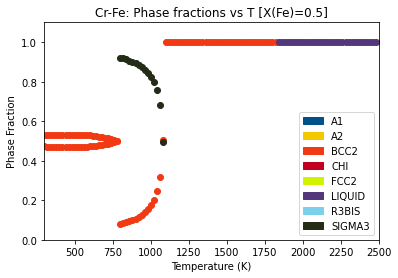

In [10]:
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_title('Cr-Fe: Phase fractions vs T [X(Fe)=0.5]')
plt.gca().set_xlabel('Temperature (K)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))
plt.gca().set_xlim((300, 2500))

for name in phases:
    phase_indices = np.nonzero(eq_alni.Phase.values == name)
    plt.scatter(np.take(eq_alni['T'].values, phase_indices[2]), eq_alni.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, loc='lower right')

In [13]:
from pycalphad import Database, equilibrium, Model, ReferenceState, variables as v
import matplotlib.pyplot as plt
import numpy as np

dbf = Database("Cr-Fe-ref2.TDB")
comps = ["CR", "FE", "VA"]
phases = dbf.phases.keys()
print(phases)
# Create reference states
Cr_ref = ReferenceState("CR","BCC2", {v.T: 298.15, v.P: 101325})
Fe_ref = ReferenceState("FE", "BCC2", {v.T: 298.15, v.P: 101325})
# Create the models for each phase and shift them all by the same reference states.
eq_models = {}
for phase_name in phases:
    mod = Model(dbf, comps, phase_name)
    mod.shift_reference_state([Cr_ref, Fe_ref], dbf)
    eq_models[phase_name] = mod
conds = {v.P: 101325, v.T: 298.15, v.X("FE"): (0, 1, 0.01)}
result = equilibrium(dbf, comps, phases, conds, output="HMR", model=eq_models)
# Find the groups of unique phases in equilibrium e.g. [CHI_RENB] and [CHI_RENB, HCP_RENB]
unique_phase_sets = np.unique(result.Phase.values.squeeze(), axis=0)

dict_keys(['LIQUID', 'A1', 'A2', 'BCC2', 'CHI', 'FCC2', 'R3BIS', 'SIGMA3'])


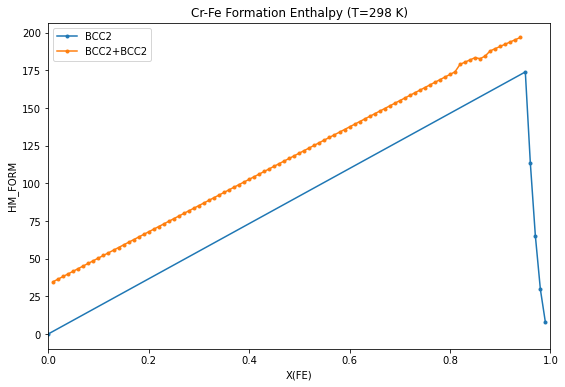

In [15]:
# Plot
fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for phase_set in unique_phase_sets:
    label = '+'.join([ph for ph in phase_set if ph != ''])
    # composition indices with the same unique phase
    unique_phase_idx = np.nonzero(np.all(result.Phase.values.squeeze() == phase_set, axis=1))[0]
    masked_result = result.isel(X_FE=unique_phase_idx)
    ax.plot(masked_result.X_FE.squeeze(), masked_result.HMR.squeeze(), marker='.', label=label)
ax.set_xlim((0, 1))
ax.set_xlabel('X(FE)')
ax.set_ylabel('HM_FORM')
ax.set_title('Cr-Fe Formation Enthalpy (T=298 K)')
ax.legend()


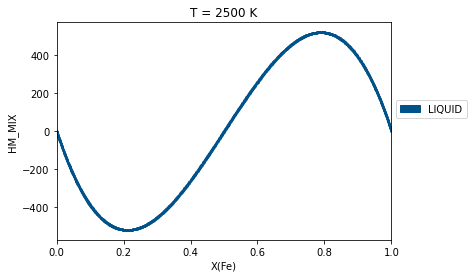

In [12]:
from pycalphad.plot.utils import phase_legend
import matplotlib.patches as mpatches

for T in [2500]:
    legend_handles, color_dict = phase_legend(phases)
    plt.figure()
    # Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(SN)
    phases=['LIQUID']
    for phase_name in phases:
        result = calculate(dbf, comps, phase_name, P=101325, T=T, N=1, output='HM_MIX')
        plt.scatter(result.X.sel(component='FE'), result.HM_MIX, marker='.', s=5, color=color_dict[phase_name], label=phase_name)

    # Format the plot
    plt.title(f'T = {T} K')
    plt.xlabel('X(Fe)')
    plt.ylabel('HM_MIX')
    plt.xlim((0, 1))
    plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
    plt.show()

CPU times: user 12min 35s, sys: 1min 1s, total: 13min 36s
Wall time: 13min 43s


<AxesSubplot:title={'center':'CR-FE'}, xlabel='X(FE)', ylabel='Temperature (K)'>

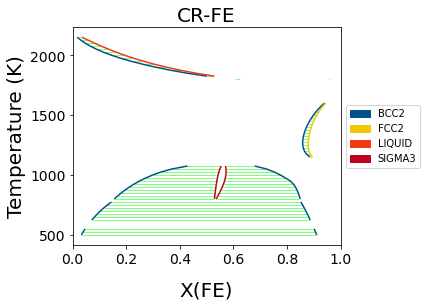

In [6]:
%%time
binplot(dbf, comps,  dbf.phases.keys(), {v.X('FE'): (0,1,0.01), v.T: (500, 2500, 25), v.P:101325, v.N: 1}, plot_kwargs={'scatter': False})